In [1]:
%matplotlib notebook
from __future__ import print_function, division
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy.stats as st
import warnings
import time
from IPython import display

# we'll be sampling from degenerate Gaussians, and numpy might complain.
warnings.filterwarnings('ignore', r'covariance is not positive-semidefinite.')

# the number of samples to show in each of the plots we create
num_samples = 100

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Bayesian linear regression as GP inference

This notebook shows visualizations demonstrating how we can think about Bayesian linear regression as inference over functions rather than over the parameters of a linear model. The basic setup is that for some known scalar $x$, we receive a scalar observation $y$ that we model as
$$
y = f(x)+\varepsilon, \quad \varepsilon \sim \mathcal{N}(0,\sigma^2)
$$
with $\sigma^2$ known and $f(x) = ax$ for some unknown scalar $a$. Our goal is then to obtain a posterior on $f(x_*)$ for some new $x_*$.

In Bayesian linear regression, we might do this by putting the following prior on $a$
$$
a \sim \mathcal{N}(0, 1/2)
$$
and then obtaining a posterior on $a$ and reporting the distribution of $f(x_*)$ under that posterior.

Here we plot visualizations of what this inference process looks like if we do it in the space of functions instead of in $\R$, where $a$ lives. Specifically, we show the prior on functions implied by our prior on $a$, along with its associated posterior over functions given the observation $(x,y)$ as well as the posterior distribution over $f(x_*)$ and the joint distribution over $(y, f(x_*))$.

### Utility functions

In [2]:
# The main plotting function
def plot_GP(sample_f, observations=[], sigma2=0,
                        joint_x1=None, joint_x2=None, joint_mean=None, joint_cov=None,
                        marg_x=None, marg_mean=None, marg_var=None):
    plt.close() # close previous figure if there is one
    grid = np.linspace(-1,1,401)
    fig = plt.figure(figsize=(12,4))
    
    # create axis for plotting the sampled functions
    functions_ax = plt.axes([0.1,0.15,0.25,0.8])
    functions_ax.set_ylim((-1,1))
    functions_ax.set_xlim((-1,1))
    functions_ax.set_xlabel('x'); functions_ax.set_ylabel('f(x)')
    
    # create axis for plotting the joint distribution of (f(x)+noise, f(x*)), if necessary
    if joint_x1 is not None:
        joint_ax = plt.axes([0.45,0.15,0.25,0.8])
        joint_ax.set_ylim((-1,1))
        joint_ax.set_xlim((-1,1))
        joint_ax.set_xlabel('f(x)+e'); joint_ax.set_ylabel('f(x*)')
        marg_ax_pos = 0.8
    else:
        marg_ax_pos = 0.45
            
    # create axis for plotting the posterior marginal corresponding to f(x*), if necesasary
    if marg_x is not None:
        marg_ax = plt.axes([marg_ax_pos,0.15,0.15,0.8])
        marg_ax.set_ylim((-1,1)); marg_ax.set_xticklabels([])
        maxprob = st.norm.pdf(marg_mean, marg_mean, np.sqrt(marg_var))
        marg_ax.set_xlim(-0.1*maxprob, maxprob);
        marg_ax.set_xlabel('P(f(x*) | y)'); marg_ax.set_ylabel('f(x*)')

    # plot any supplied data on top the sampled functions
    for o in observations:
        functions_ax.scatter(o[0], o[1], color='k')
        
    # plot dashed vertical lines corresponding to x and x* on the relevant axes
    if joint_x1 is not None:
        functions_ax.vlines(joint_x1, -1, 1, linestyles='dashed')
        functions_ax.vlines(joint_x2, -1, 1, linestyles='dashed')
        # we cheat here by finding the closest grid point to the desired points
        # we'll use that information later to sample something close to
        # f(x1) or f(x2)
        joint_x1_ind = np.searchsorted(grid, joint_x1)
        joint_x2_ind = np.searchsorted(grid, joint_x2)
    if marg_x is not None:
        functions_ax.vlines(marg_x, -1, 1, linestyles='dashed')
        # same cheating of finding the closest grid point to marg_x
        marg_x_ind = np.searchsorted(grid, marg_x)
    
    # sample functions and plot them, together with samples from any relevant marginals
    for i in range(num_samples):
        fxs = sample_f(grid)
        functions_ax.plot(grid, fxs, color='b', alpha=0.2)
        if joint_x1 is not None:
            joint_ax.scatter(
                fxs[joint_x1_ind] + np.random.normal(0,np.sqrt(sigma2)),
                fxs[joint_x2_ind],
                s=1)
        if marg_x is not None:
            marg_ax.scatter(
                maxprob*0.01*np.random.randn(1), # we add a small jitter so close points can be distinguished
                fxs[marg_x_ind],
                s=1)
        fig.canvas.draw()
        
    # overlay pdf of joint distribution of (f(x)+e, f(x*)), if supplied
    if joint_mean is not None:
        X, Y = np.meshgrid(np.arange(-1,1,0.01), np.arange(-1,1,0.01))
        joint = mlab.bivariate_normal(X, Y,
                                  sigmax=np.sqrt(joint_cov[0,0]),
                                  sigmay=np.sqrt(joint_cov[1,1]),
                                  mux=joint_mean[0], muy=joint_mean[1],
                                  sigmaxy=joint_cov[1,0])
        joint_ax.contour(X,Y,joint, colors='b')
        
    # overlay pdf of posterior marginal over f(x*), if supplied
    if marg_mean is not None:
        marg_ax.plot(st.norm.pdf(grid, marg_mean, np.sqrt(marg_var)), grid)
        
    fig.canvas.draw()
    return fig # return fig so additional stuff can be added to it if desired

In [3]:
# This function plots the prior described by a linear kernel, together with
# marginals of that prior corresponding to either (f(x1), f(x2)), f(x2), or both
def plot_prior(x1=None, x2=None, sigma2=None, show_2d_marg=False, show_1d_marg=False):
    def sample_from_prior(grid):
        return np.random.multivariate_normal(np.zeros(len(grid)), linear_kernel(grid, grid))

    if not show_2d_marg and not show_1d_marg:
        return plot_GP(sample_from_prior, sigma2=sigma2)
    else:
        myxs = np.array([x1,x2])
        mycov = linear_kernel(myxs, myxs) + sigma2*np.diag([1,0])
        if show_2d_marg and show_1d_marg:
            return plot_GP(sample_from_prior, sigma2=sigma2,
                joint_x1=x1, joint_x2=x2,
                joint_mean=np.zeros(len(myxs)),
                joint_cov=mycov,
                marg_x=x2, marg_mean=0, marg_var=mycov[1,1])
        elif show_2d_marg and not show_1d_marg:
            return plot_GP(sample_from_prior, sigma2=sigma2,
                joint_x1=x1, joint_x2=x2,
                joint_mean=np.zeros(len(myxs)),
                joint_cov=mycov)
        else:
            return plot_GP(sample_from_prior, sigma2=sigma2,
                marg_x=x2, marg_mean=0, marg_var=mycov[1,1])        

In [4]:
# This function plots the posterior under the linear kernel, conditioned on the observation
# (x1, y1), potentially together with the posterior marginal distribution over f(x2)
def plot_posterior(x1, y1, sigma2, x2=None, show_marginal=False):
    def sample_from_posterior(grid):
        post_m, post_c = posterior(np.array([x1]), np.array([y1]), grid,
                                lambda xs,morexs:linear_kernel(xs,morexs),
                                sigma2)
        return np.random.multivariate_normal(post_m, post_c)
    if show_marginal:
        marginal_post_m, marginal_post_c = posterior(np.array([x1]), np.array([y1]), np.array([x2]),
                                lambda xs,morexs:linear_kernel(xs,morexs),
                                sigma2)
        return plot_GP(sample_from_posterior, observations=[[x1,y1]], sigma2=sigma2,
                            marg_x=x2, marg_mean=marginal_post_m[0], marg_var=marginal_post_c[0,0])
    else:
        return plot_GP(sample_from_posterior, observations=[[x1,y1]], sigma2=sigma2)

In [5]:
def posterior(xs, ys, newxs, kernel, sigma2, mean=(lambda g:np.zeros(len(g)))):
    Kold = kernel(xs, xs)
    Koldnew = kernel(xs, newxs)
    Knewold = Koldnew.T
    Knew = kernel(newxs, newxs)
    A = np.linalg.inv(Kold + sigma2*np.eye(len(Kold)))
    return mean(newxs) + Knewold.dot(A.dot(ys-mean(xs))), (Knew - Knewold.dot(A.dot(Koldnew)))

In [6]:
def linear_kernel(xs, morexs):
    return 0.5*np.outer(xs,morexs)

### 1. The prior over functions induced by $a \sim \mathcal{N}(0, \tau^2)$

We start by sampling $a$ from the normal prior and then plotting, for each sampled $a$, a graph of the corresponding function $f(x)=ax$. This is our prior over functions

<IPython.core.display.Javascript object>


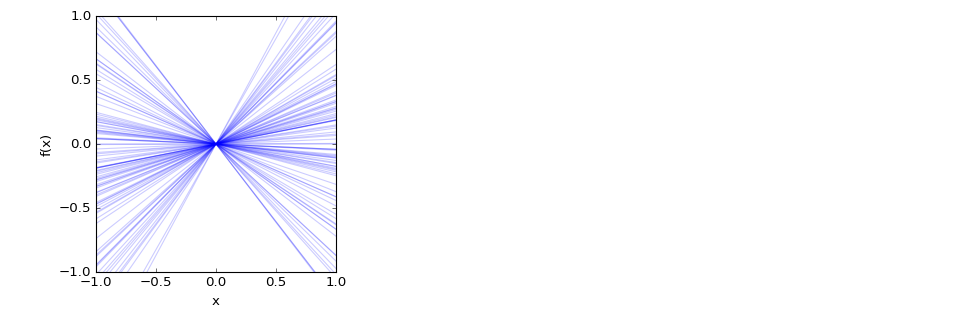

In [7]:
plot_prior();

### 2. Posterior over functions after one observation

Once we see the observation $(x,y)$, we can adjust our prior on $a$ to obtain a posterior. An conceptually equivalent operation is to adjust our prior on $f$ to obtain a posterior. The plot below shows that posterior for the observation $(x,y) = (0.4,0.2)$. Notice that now most of the functions drawn from the posterior are "close" to the function $f(x)=x/2$, which is the mode of this distribution. This makes sense because since our observed $y$ is half our observed $x$, $f(x)=x/2$ is the function with the strongest support from the data.

Question: why don't all the functions pass exactly through the point $(0.4,0.2)$?

<IPython.core.display.Javascript object>


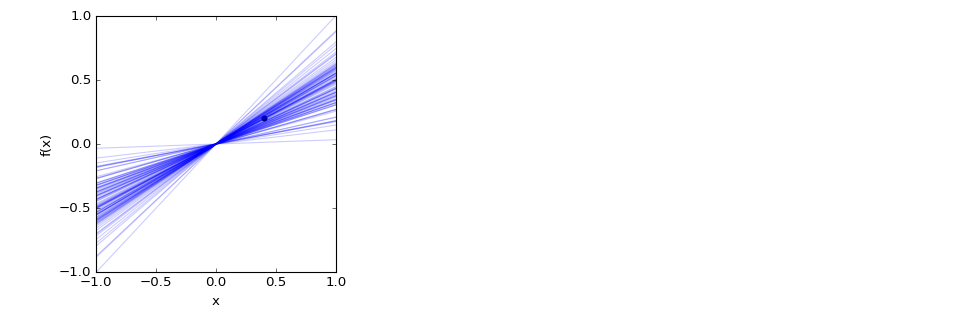

In [8]:
plot_posterior(0.4,0.2,0.005);

Now suppose we are asked about the value of $f$, given our data, at $x_* = 0.8$ (dotted line in plot below). To answer the question, we show the same posterior over $f$ as before, only we also explicitly compute $f(x_*)$ for each $f$ that we sample, and we keep track of those on the side as well. This distribution over $f(x_*)$ is the posterior we actually care about.

<IPython.core.display.Javascript object>


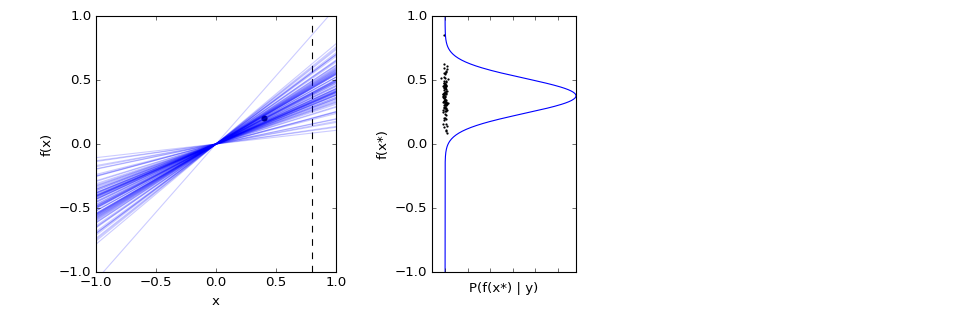

In [9]:
plot_posterior(0.4,0.2,0.005, x2=0.8, show_marginal=True);

### 3. A prior on functions induces a distribution on $(f(x)+\varepsilon, f(x_*))$

We now examine how we can do inference on functions directly by focusing specifically on their values at the points that we have seen and the points we want to predict. Here we plot the prior over $f$, but each time we sample a function, we also evaluate it at $x$ and at $x*$ (both represented by dotted lines). The right-hand plot shows the corresponding samples from $f(x)+\varepsilon$ and $f(x_*)$ plotted against each other. We showed in the lecture that these two random variables are jointly Gaussian. This is the key to GP inference.

<IPython.core.display.Javascript object>


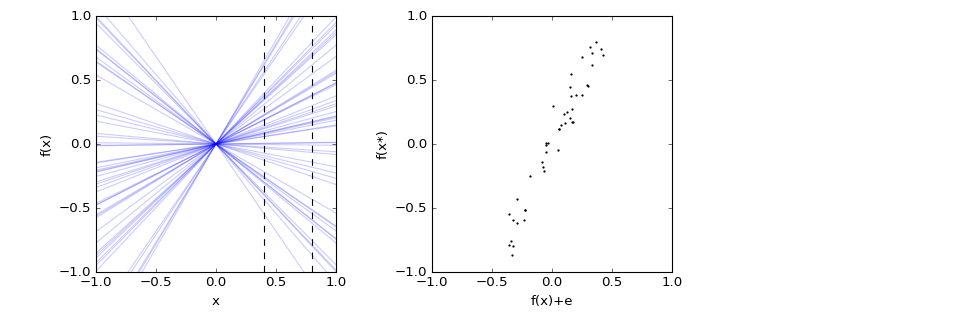

In [ ]:
plot_prior(x1=0.4, x2=0.8, sigma2=0.005, show_2d_marg=True);

The last step is to see that our posterior over $f(x_*)$ can be viewed simply as a conditional distribution of the 2D Gaussian above. This is represented by the right-most plot in the figure below. The fact that the posterior is a conditional of a Gaussian distribution makes it really easy to compute, since conditioning for Gaussians is a closed-form operation.

In [ ]:
post_m, post_c = posterior(np.array([0.4]), np.array([0.2]), np.array([0.8]),
                                lambda xs,morexs:linear_kernel(xs,morexs),
                                0.005)
maxprob = st.norm.pdf(post_m[0], post_m[0], np.sqrt(post_c[0,0]))

# plot the joint distribution over the data and the prediction
fig = plot_prior(x1=0.4, x2=0.8, sigma2=0.005, show_2d_marg=True)

# add the posterior as a conditional of the joint
axes = fig.get_axes()
axes[1].vlines(0.2, -1, 1)
cond_ax = plt.axes([0.8,0.15,0.15,0.8])
cond_ax.set_ylim((-1,1)); cond_ax.set_xticklabels([])
cond_ax.set_xlim(-0.1*maxprob, maxprob);
cond_ax.set_xlabel('P(f(x*) | y)'); cond_ax.set_ylabel('f(x*)')
cond_ax.plot(st.norm.pdf(np.linspace(-1,1,401), post_m[0], np.sqrt(post_c[0,0])), np.linspace(-1,1,401));